In [99]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import doctest
import copy

In [100]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Unicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$

Use the Kinematics equations we had developed in class for the Unicycle model

In [110]:
#uncomment this decorator to test your code
@test 
def unicycle_model(curr_pose, v, w, dt=1):
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta = theta + w*dt; 
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

Finding tests in unicycle_model
Trying:
    unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
Expecting:
    (0.0, 0.0, 1.0)
ok
Trying:
    unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
Expecting:
    (1.0, 0.0, 1.0)
ok


Now let us try to simulate motion along a straight line and circle

Look at the kinematics equations you wrote - what should $v,\omega$ if
+ There is no change in $\theta$
+ $\theta$ has to change from 0 to 360 degrees

In [104]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps)
all_w = np.zeros(steps)
for v, w in zip(all_v,all_w):
   straight_trajectory.append(pose)
   #instruction to take v, w and compute new pose    
   pose = unicycle_model(pose,v,w) 
   # store new pose

straight_trajectory = np.array(straight_trajectory)
    

In [108]:
#circle (change the value of dt to 0.1 to get smooth circular trajectory)
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 100
#fill in v and omega values
all_v = np.ones(steps) 
all_w = np.ones(steps)
for v,w in zip(all_v,all_w):
  circle_trajectory.append(pose)
  pose = unicycle_model(pose, v, w)
    #instruction to take v, w and compute new pose    

   # store new pose
circle_trajectory = np.array(circle_trajectory)


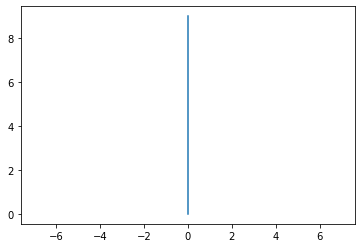

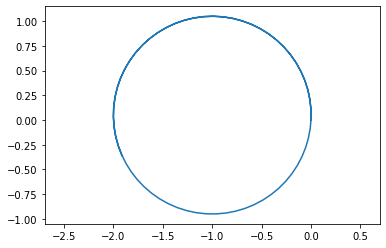

In [111]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal", "datalim")
plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])

### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal", "datalim")
plt.plot(circle_trajectory[:,0], circle_trajectory[:,1])


### Simulate Unicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\omega$. To make it even simpler, $\omega$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\omega = \omega_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\omega_c$?
* When should $\omega$ change from 0 and back?

In [112]:
v_c = 1 # m/s
w_c = np.pi/6 # rad/s

#calculate time taken to finish a quarter turn (pi/2)
t_turn = int(np.pi/2/w_c)

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c), int(5/v_c), int(8/v_c) 

all_w = [0]*t_straight1 + [w_c]*t_turn + \
        [0]*t_straight2 + [w_c]*t_turn + \
        [0]*t_straight3 + [-w_c]*t_turn
all_v = v_c*np.ones_like(all_w)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_w

In [113]:
def get_open_loop_commands(route, vc , wc): 
    all_w = []
    omegas = {'straight':0, 'left':wc, 'right': -wc}
    t_turn = int(np.pi/4/wc)
    for manoeuvre, command in route:
      u = np.ceil(command/vc).astype('int')
      v = np.ceil(np.deg2rad(command/wc)).astype('int')
      t_cmd = u if manoeuvre == 'straight' else v
      all_w += [omegas[manoeuvre]]*t_cmd
    all_v = vc*np.ones_like(all_w)
    return all_v, all_w

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $w_c = \pi/12$

In [114]:
all_v, all_w = get_open_loop_commands([("straight", 10), ("right", 90), ("straight", 5), ("left", 90), ("straight", 8), ("right", 90)], 1, np.pi/12)

In [115]:
print(all_v)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [116]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose
    robot_trajectory.append(pose)
    pose = unicycle_model(pose,v,w)

robot_trajectory = np.array(robot_trajectory)
   # store new pose

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


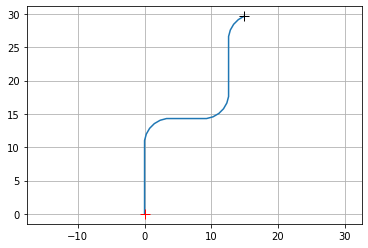

In [117]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.axes().set_aspect("equal","datalim") # this command was added intentionally to observe trajectory on graph with axes of equal length
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1])

#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi, yi,'r+', ms = 10)
plt.plot(xf, yf,'k+', ms = 10)

### Improved capabilities!

+ Slow the robot while turning ($v_c$ for turn and straight needed)

+ How to accommodate a sampling time < 1.0s (hint: think of sampling instances instead of time)

In [118]:
## Solution for : Slow the robot while turning ( vc  for turn and straight needed) 
##--------------------------------------------------------------------
def get_open_loop_commands1(route, vc1 , vc2 , wc):  ## The get_open_loop_commands was changed to get_open_loop_commands1 to accomodate variable forward speed 
    all_w = []
    all_v = []
    omegas = {'straight':0, 'left':wc, 'right': -wc}
    #t_turn = int(np.pi/4/wc)
    for manoeuvre, command in route:
      u = np.ceil(command/vc1).astype('int')
      v = np.ceil(np.deg2rad(command/wc)).astype('int')
      t_cmd = u if manoeuvre == 'straight' else v
      all_w += [omegas[manoeuvre]]*t_cmd
    for i in range(len(all_w)): ## The code ahead will ensure that truns are taken at slower speeds
      if (all_w[i] == 0):
        all_v.append(vc1)
      else:
        all_v.append(vc2)

    all_v = np.array(all_v)
    return all_v, all_w

In [119]:
all_v1, all_w1 = get_open_loop_commands1([("straight", 10), ("right", 90), ("straight", 5), ("left", 90), ("straight", 8), ("right", 90)], 1, 0.5, np.pi/12)

In [120]:
print(all_v1)

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 0.5 0.5 0.5 0.5 0.5 1.  1.
 1.  1.  1.  0.5 0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.  1.  1.  1.  1.  0.5
 0.5 0.5 0.5 0.5 0.5]


In [122]:
robot_trajectory1 = []
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v1, all_w1):
    #instruction to take v, w and compute new pose
    robot_trajectory1.append(pose)
    pose = unicycle_model(pose,v,w,1) #dt = 1

robot_trajectory1 = np.array(robot_trajectory1)
   # store new pose

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


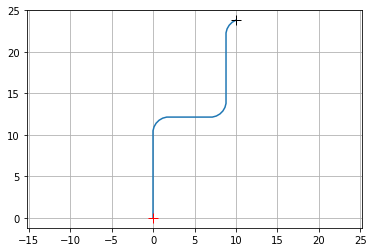

In [123]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory1[:,0], robot_trajectory1[:,1])

#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)
xi, yi, _ = robot_trajectory1[0]
xf, yf, _ = robot_trajectory1[-1]
plt.plot(xi, yi,'r+', ms = 10)
plt.plot(xf, yf,'k+', ms = 10)

In [96]:
## Solution for: How to accommodate a sampling time < 1.0s (hint: think of sampling instances instead of time)

def unicycle_model2(curr_pose, v, w, dt): ## In this function- unicycle_model2 user can define 'dt' of its own
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta = theta + w*dt; 
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

In [124]:
def get_open_loop_commands2(route, vc1 , vc2 , wc, dt):   ## In get_open_loop_commands2 user can define dt of its own
    all_w = []
    all_v = []
    omegas = {'straight':0, 'left':wc, 'right': -wc}
    #t_turn = int(np.pi/4/wc)
    for manoeuvre, command in route:
      u = np.ceil(command/vc1).astype('int')  #Time for straignt motion
      v = np.ceil(np.deg2rad(command/wc)).astype('int') # Time for turning motion
      steps = int(u/dt) if manoeuvre == 'straight' else int(v/dt)  #Dividing the time of individual motion ny dt to obtain the number of steps
      all_w += [omegas[manoeuvre]]*steps  ##Now the length of arrays all_m and all_v should be equal to the number of steps
    for i in range(len(all_w)): ## The code ahead will ensure that turns are taken at slower speeds
      if (all_w[i] == 0):
        all_v.append(vc1)
      else:
        all_v.append(vc2)

    all_v = np.array(all_v)
    return all_v, all_w

In [125]:
all_v2, all_w2 = get_open_loop_commands2([("straight", 10), ("right", 90), ("straight", 5), ("left", 90), ("straight", 8), ("right", 90)], 1, 0.5, np.pi/12, 0.1) # choose dt 

In [ ]:
print(all_v2)

In [129]:
robot_trajectory2 = []
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v2, all_w2):
    #instruction to take v, w and compute new pose
    robot_trajectory2.append(pose)
    pose = unicycle_model2(pose,v,w,.1)  #Choose same dt as used while generating the route

robot_trajectory2 = np.array(robot_trajectory2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


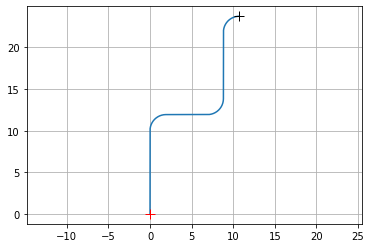

In [131]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory2[:,0], robot_trajectory2[:,1])

#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)
xi, yi, _ = robot_trajectory2[0]
xf, yf, _ = robot_trajectory2[-1]
plt.plot(xi, yi,'r+', ms = 10)
plt.plot(xf, yf,'k+', ms = 10)

#With higher number of steps, a perfect 90 degree turn can be observed
